# Visualizing MSI Images with Parametric UMAP.

Binning with m/z from 900 is used to create the segmentation.
Then we train parametric umap using only the non noise bins, with 1 output.

In [ ]:
import numpy as np
import joblib
from sklearn.decomposition import non_negative_factorization
from sklearn.metrics.pairwise import cosine_similarity
from visualizations import get_colors, show_factorization_on_image, visualizations_from_explanations
from matplotlib import pyplot as plt
from PIL import Image


NUM_COMPONENTS = 5
_cmap = plt.cm.get_cmap('gist_rainbow')
colors_for_components = [
    np.array(
        _cmap(i)) for i in np.arange(
        0,
        1,
        1.0 /
        NUM_COMPONENTS)]

# Create the segmentation mask/
ion_image = np.load("D:\\maldi\\tol_01_binarysearch_1_bin\\0.npy")
ion_image = ion_image[:, :, 600 :]
H = np.load("h_cosegmentation.npy")
ion_image = ion_image / (1e-6 + np.median(ion_image, axis=-1)[:, :, None])
vector = ion_image.reshape((-1, ion_image.shape[-1]))
w_new, h_new, n_iter = non_negative_factorization(vector, H=H, W=None, n_components=NUM_COMPONENTS, update_H=False, random_state=0)
explanations = w_new.transpose().reshape(NUM_COMPONENTS, ion_image.shape[0], ion_image.shape[1])
explanations[4, :] = 0
spatial_sum_visualization, global_percentile_visualization, normalized_sum, normalized_percentile = visualizations_from_explanations(ion_image, explanations, colors_for_components)
segmentation_mask = normalized_sum.argmax(axis=0)
segmentation_mask[ion_image.max(axis=-1) == 0] = 0
display(Image.fromarray(spatial_sum_visualization))

# Create the training data from the first image.
ion_image = np.load("D:\\maldi\\tol_None_5_bins\\0.npy")
ion_image = ion_image / (1e-6 + np.median(ion_image, axis=-1)[:, :, None])
ion_image[normalized_sum.argmax() == 3] = 0


ion_image[segmentation_mask == 0] = 0
training_data = ion_image[::2, ::2, :].reshape(-1, ion_image.shape[-1])
training_data = training_data[training_data.max(axis=-1) > 0]
print(training_data.shape)

# Define the parametric UMAP deep neural network.
5005 outputs since we use the full range.

In [ ]:
from umap.parametric_umap import ParametricUMAP
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf

encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(5005,)),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=1)
])

umap_model = ParametricUMAP(encoder=encoder, n_components=1, n_neighbors=50, n_training_epochs=1, dims=(5005,), run_eagerly=True).fit(training_data)

umap_model.encoder.save("D:\\maldi\\parametric_umap_tol_None_5_bins.keras")

d:\miniconda3\envs\dl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


82/82 [==============================] - 1s 12ms/step
Colored image without region specific normalization


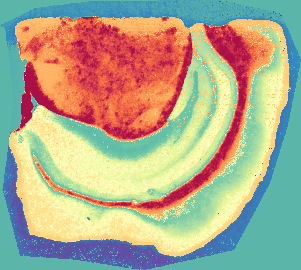

1D UMAP with per region color mapping


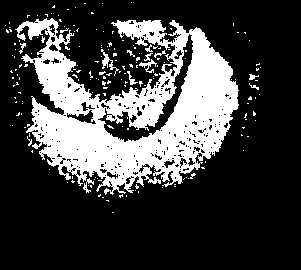

100%|██████████| 930/930 [00:03<00:00, 273.44it/s]


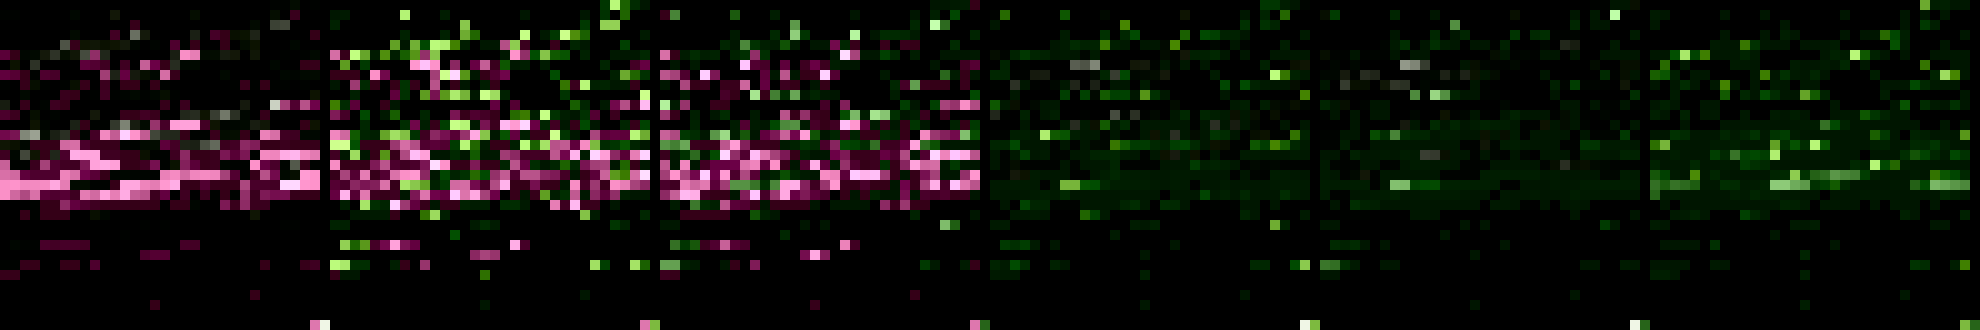

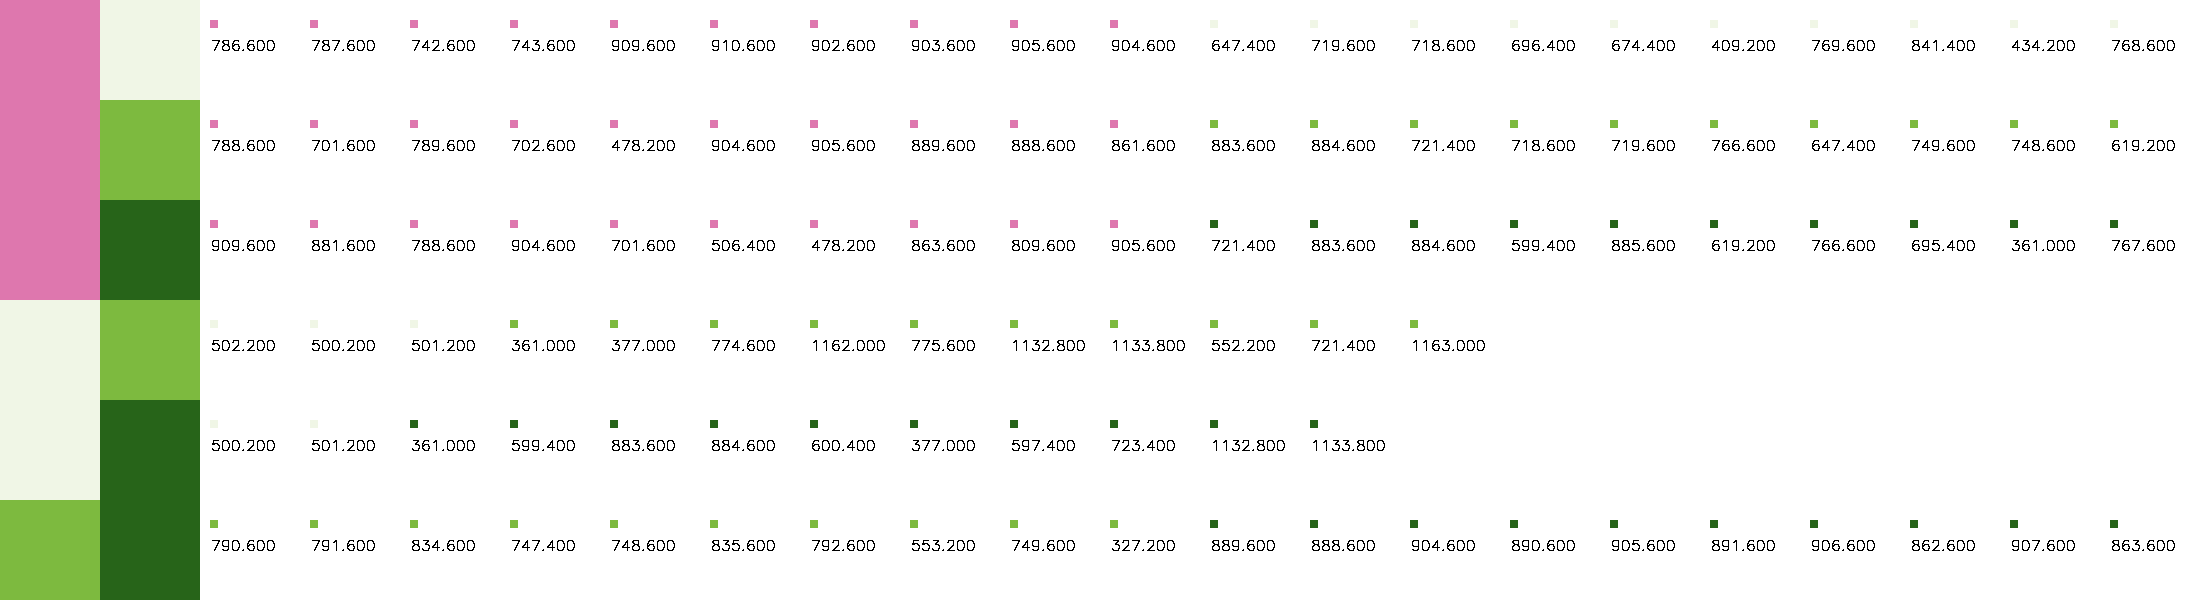

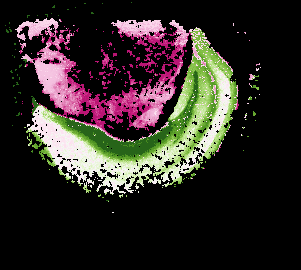

In [1]:
from PIL import Image
import cv2
import joblib
import numpy as np
from umap.parametric_umap import load_ParametricUMAP
import glob
from parametric_umap import normalize_image_grayscale, image_histogram_equalization
from utils import brain_nmf_semantic_segmentation
import tensorflow as tf
from sklearn.decomposition import non_negative_factorization
from visualizations import get_colors, get_qr_images, analyze_region_differences, get_difference_summary_table
from matplotlib import pyplot as plt
from collections import defaultdict
import tqdm
import cmapy

encoder = tf.keras.models.load_model("D:\\maldi\\parametric_umap_tol_None_5_bins.keras")
lowres_paths = glob.glob("D:\\maldi\\tol_01_binarysearch_1_bin\\*.npy")
highres_paths = glob.glob("D:\\maldi\\tol_None_5_bins\\*.npy")
colors_maps=["Spectral", "PiYG", "RdGy", "seismic"]
#colors_maps = ["gist_rainbow", "hsv", "seismic", "cividis"]
#colors_maps = ["hsv", "twilight", "twilight_shifted", "seismic"]
for image_index, (path_for_segmentation, path_for_umap) in enumerate(zip(lowres_paths, highres_paths)):
    if image_index > 0:
        continue
    semantic_segmentation_labels = brain_nmf_semantic_segmentation(path_for_segmentation)

    ion_image = np.load(path_for_umap)
    ion_image = ion_image / (1e-6 + np.median(ion_image, axis= -1)[:, :, None])
    transformed = encoder.predict(ion_image.reshape(-1, ion_image.shape[-1]), batch_size=1000)
    transformed = transformed.reshape((ion_image.shape[0], ion_image.shape[1]))
    result = []
    print('Colored image without region specific normalization')
    num_bins = 2048
    normalized_transformed = normalize_image_grayscale(transformed)
    normalized_transformed = image_histogram_equalization(normalized_transformed, ion_image.max(axis=-1) > 0, num_bins) / (num_bins - 1)
    colored_image = np.uint8(normalized_transformed*255)
    colored_image = cv2.applyColorMap(colored_image, cmapy.cmap(colors_maps[0]))[:, :, ::-1]
    display(Image.fromarray(colored_image))
    print('1D UMAP with per region color mapping')

    for index, value in enumerate(np.unique(semantic_segmentation_labels)[1:2]):
        mask = np.uint8(semantic_segmentation_labels == value) * 255
        mask[ion_image.max(axis=-1) == 0] = 0
        mask = cv2.medianBlur(mask, 3)
        mask[ion_image.max(axis=-1) == 0] = 0
        display(Image.fromarray(mask))
        region_umap_representation = transformed.copy()
        region_umap_representation[mask == 0] = 0

        num_bins = 2048
        region_umap_representation = normalize_image_grayscale(region_umap_representation)
        region_umap_representation = image_histogram_equalization(region_umap_representation, mask, num_bins) / (num_bins - 1)
        region_gray_image = np.uint8(region_umap_representation * 255)
        region_color_image = cv2.applyColorMap(region_gray_image, cmapy.cmap(colors_maps[value]))
        region_color_image = region_color_image[:, :, ::-1]
        region_color_image[mask == 0] = 0
        result.append(region_color_image)
        
        mzs_per_bin = 1
        bins, digitized, region_pair_aucs = analyze_region_differences(ion_image, region_gray_image, mzs_per_bin, number_of_bins=3)
        qr_images = get_qr_images(region_gray_image, bins, digitized, region_pair_aucs, mzs_per_bin, color_scheme=colors_maps[value])
        display(Image.fromarray(np.hstack(qr_images)))
        
        top_mzs = {}
        for (i, j) in region_pair_aucs:
            _, full_range_aucs = region_pair_aucs[(i, j)]
            top_mzs[(i, j)] = {k: v for k, v in sorted(full_range_aucs.items(),
                                                key=lambda item: abs(item[1]))[::-1][:2000]}

    
    table = get_difference_summary_table(region_gray_image, digitized, bins, top_mzs, colors_maps[value])
    display(Image.fromarray(table))
    
    result = np.array(result)
    result = result.sum(axis=0)    
    result[np.array(ion_image.max(axis=-1) == 0)] = 0
    display(Image.fromarray(np.uint8(result)))